In [29]:
%load_ext autoreload
%autoreload 2

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

import sys
sys.path.insert(0, "..") 

from src.data import make_dataset
from src.visualization import visualize
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Perofrmance metrics

Let's load the MNIST dataset. This is a dataset of handwritten numbers. You will encounter it in a lot of machine learning tutorials.

In [3]:
(X_train, y_train, X_test, y_test) = make_dataset.main(validation=False)
X_train.shape

(60000, 28, 28)

The shape is (60000, 28,28) for the trainset. This means: we have 60000 cases, and every case is a 28x28 matrix. We can visualize a single instance:

y_train = 2


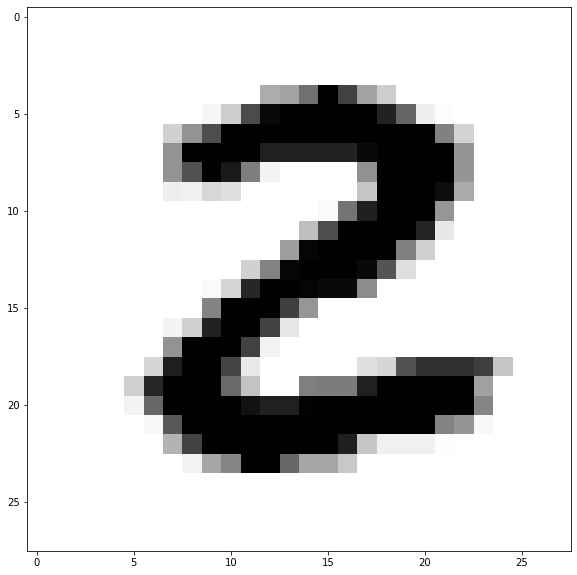

In [4]:
idx = 25 #let's have a look at case 25. You can change this to have a look at others
digit = X_train[idx]
plt.imshow(digit, cmap='binary')
print(f"y_train = {y_train[idx]}")

For simplicity, let's focus on predicting the cases with number 3 only. That is, we want to tackle the *binary classification* task to know whether a given image represents the number 3 or not.

In [5]:
y_train_single, y_test_single = make_dataset.set_number(y_train, y_test, nbr=3)

np.mean(y_train_single) , np.mean(y_test_single)

(0.10218333333333333, 0.101)

Let's check how balanced the dataset is

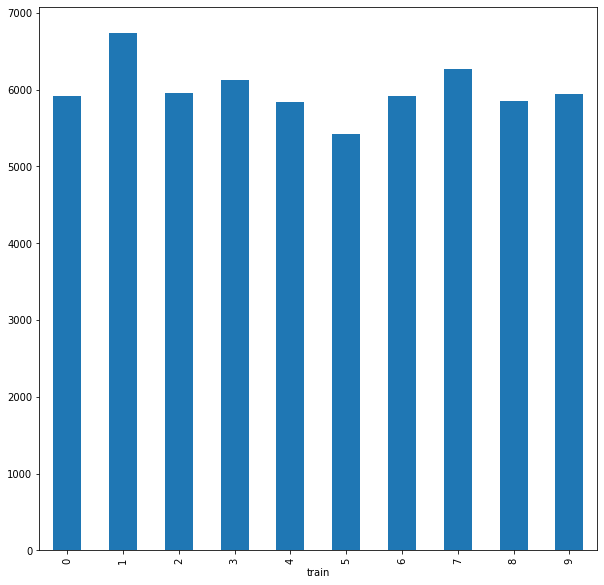

In [8]:
visualize.class_balance(y_train, 'train')

We can see that about 10% of the dataset is a three. This is what you would expect for an evenly distributed set, which the barplot confirms. Now lets reshape the 28x28 matrices to a vector of 28x28=784 numbers.

In [11]:
# the -1 tells the method .reshape() to reshape to a matrix where the amount that should be at -1 is deducted from the other amounts.
# because the first number is 60.000, reshape will make sure the second value is 784, because that is the only way
# to make a matrix with 60.000 rows, in this case.
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(60000, 784)

What we are actually doing, is reshaping the grid into one long vector. While that might be a weird representation for an image, it works suprisingly well for a classifier.

Can you understand, what the classifier is doing with this representation? Could you explain in normal language what the strategy of this approach is? The logic of why this works? What would be a downside of this approach?

Now, let's fit a stochastic gradient classifier.

In [12]:
sgd = SGDClassifier(random_state=5, max_iter=10, n_jobs=4)
sgd.fit(X_train, y_train_single)

SGDClassifier(max_iter=10, n_jobs=4, random_state=5)

Let's visualize what the model is doing, in terms of weight. Can you explain what the model is doing, and why?

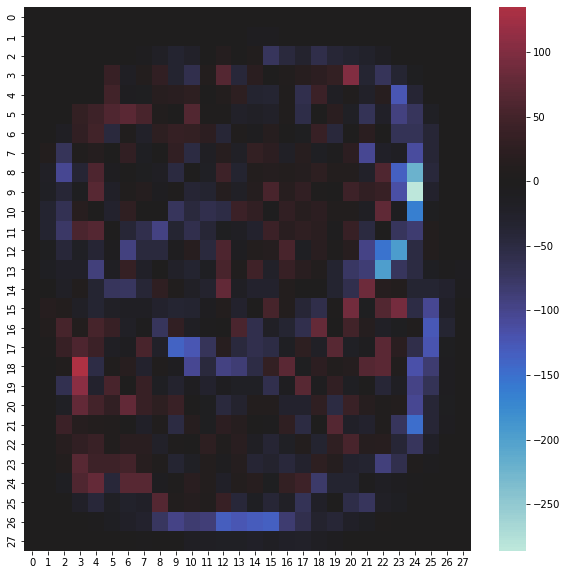

In [13]:
weights = sgd.coef_.reshape(28, 28)
sns.heatmap(weights, center = 0);

Let's select `accuracy` as metric and check how well we classified images as threes:

In [16]:
cross_val_score(sgd, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.96585, 0.95275, 0.95815])

That looks great. But don't cheer to fast...When building a machine learning model you should always compare its performance (in this case the `accuracy`) to a *baseline* model. For this case, let's see how a *dummy classifier* performs. A dummy classifier is a simple model that just picks the most frequent occurence in the dataset as its prediction. In our case 90% of the dataset is NOT a three, so the dummy will predict that everything is NOT a three.

**Note**: this is not the only possible choice for a dummy classifier. Can you think of other simple prediction strategies that could be taken as baseline models?

In [18]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_single)
cross_val_score(dummy_majority, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.89785, 0.8978 , 0.8978 ])

Ouch! Those are pretty high scores too. This *may* imply that our machine learning model is not really doing much better than the baseline model.  However, before jumping to this conclusion, we should also ask ourselves whether the metric we are using to evaluate the model's performance is appropriate for our task. 

This should be a lesson about the problems you could encounter when trying to assess performance on an unbalanced dataset.

Let's visualize the *confusion matrix*, i.e. a summary visualization of the predictions of our model against the ground truth. 

f1-score = 0.0


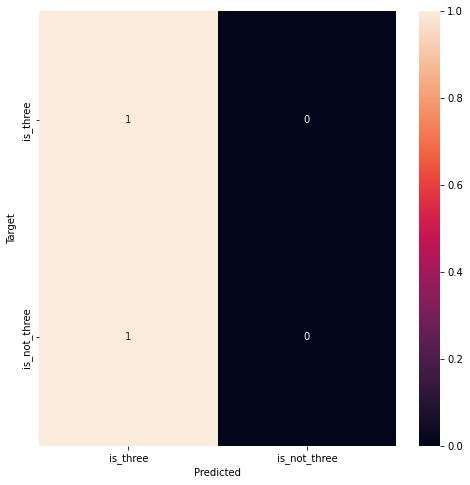

In [20]:
yhat_dummy = dummy_majority.predict(X_test)

cfm = confusion_matrix(y_test_single, yhat_dummy)
visualize.cfm_heatmap(cfm, scale = 'rowwise', labels=['is_three', 'is_not_three'])

print(f"f1-score = {f1_score(y_test_single, yhat_dummy)}")

So, what is going on? Well, we see that in the column predicted, everything is predicted as `is_three`. This means that the dummy model accurately predicts the 90% of the dataset whose label `is_not_three`. However, it makes wrong predictions for all that 10% of the dataset whose label `is_three`. The F1-score is a useful metric for problems with unblanaced datasets; it returns a number between 0 and 1 that gives an indication of how well a model is doing in the classification task. Other useful metrics are *precision* and *recall*.

**Precision**: how many of the samples *predicted* as positive are actually positive

$$ Precision = \frac{TP}{TP + FP}$$

**Recall**: how many of *actual* positive samples are indeed predicted as positive

$$ Recall = \frac{TP}{TP + FN}$$

**F-score**: the harmonic mean of precision and recall

$$ F = 2 * \frac{precision * recall}{precision + recall} $$

The F1-score of the dummy classifier is zero! Let's make a confusion matrix of the SGD classifier and computes its F1-score.

f1-score = 0.8256513026052105


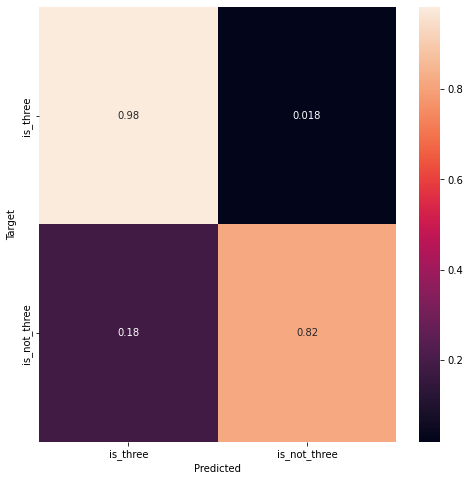

In [21]:
y_test_hat = sgd.predict(X_test)

cfm = confusion_matrix(y_test_single, y_test_hat)
visualize.cfm_heatmap(cfm, scale = 'rowwise', labels=['is_three', 'is_not_three'])

print(f"f1-score = {f1_score(y_test_single, y_test_hat)}")

This looks much better. This should also make clear, how you can be deceived with a simple accuracy measure, but you can see a difference in performance if you look at the confusion matrix.

 We normalized rowwise, wich means that the rows (the actual label) sum up to 1. We see that we predicted 82 percent of the actual threes indeed as a three, making an error in 18% of the cases. We also mistook 1.8% of the non-threes for a three. So let's look at what's going on internally:

In [23]:
y_decision = cross_val_predict(sgd, X_train, y_train_single, cv = 3, n_jobs = 4, method = 'decision_function')

/Users/zbelligoli/opt/anaconda3/envs/ml-21/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/Users/zbelligoli/opt/anaconda3/envs/ml-21/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/Users/zbelligoli/opt/anaconda3/envs/ml-21/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Let's have a look at the first few values.

In [24]:
val = zip(y_decision[5:10], y_train_single[5:10])
pd.DataFrame(val)

,0,1
0,-316072.225685,False
1,-97063.724417,False
2,161748.616761,True
3,-94219.428047,False
4,-251240.692439,False


You can probably figure out what is going on. Low values mean `is_not_three`, high values mean `is_three`. There is a fixed number called *threshold* above which all instances are classified as `is_three`. By changing the value of the threshold, we can change the behavior of the classifier to be more strict, or more loose when it comes deciding if something is a three, or not.

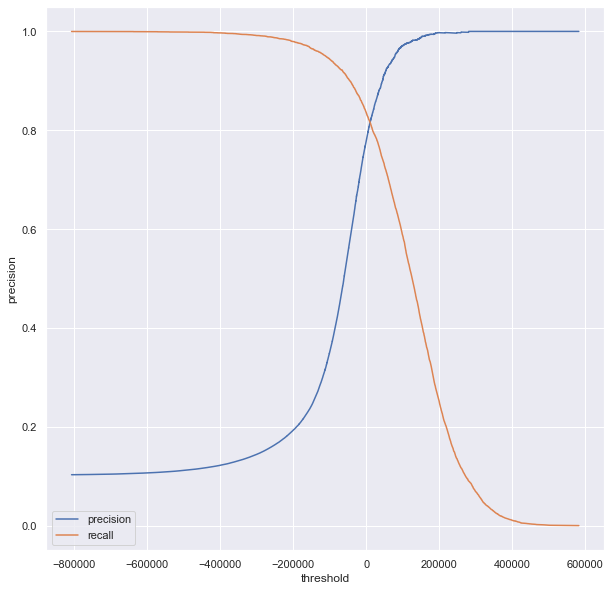

In [31]:
precision, recall, thresholds = precision_recall_curve(y_train_single, y_decision)
visualize.precision_recall_curve(precision, recall, thresholds)

As you might have figured out by now, this plot shows that you can achieve any precision you want! The only problem is that your recall will drop, and vice versa... In some cases you could want to tune this threshold.

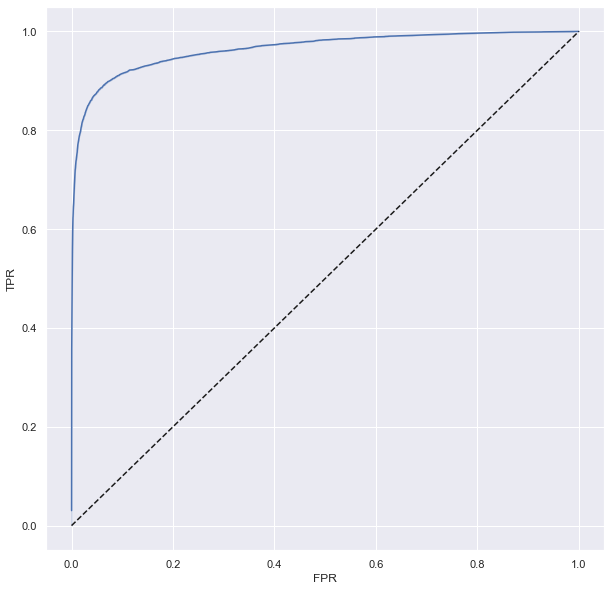

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_single, y_decision)
visualize.roc_curve(fpr, tpr)

Another visualization that is often used, is a ROC-curve. You plot the False Positive Rate against the True Positive Rate. The diagonal line is what you expect from coincence, so you should get away from that.

The steep rise means: even though the False Positive Rate is very low, you identify already about 60-80% of the True Positive cases. That is nice!

If you also want to get those last difficult cases, you will have to accept that your False Positive rate will also grow, meaning that you will make more mistakes in giving something a label while you should not have done so.

##  Multiclass
Now let's move on to a more complex case, where we actually want to predict every number.

In [35]:
# first scale the data
X_scale = make_dataset.scale(X_train)

2021-11-22 11:26:18.682 | INFO     | src.data.make_dataset:scale:16 - Run standardscaler on data.


In [36]:
# then fit a SGD classifier
sgd = SGDClassifier(random_state=5, max_iter=50, n_jobs=4)
yhat = cross_val_predict(sgd, X_scale, y_train, cv = 3)

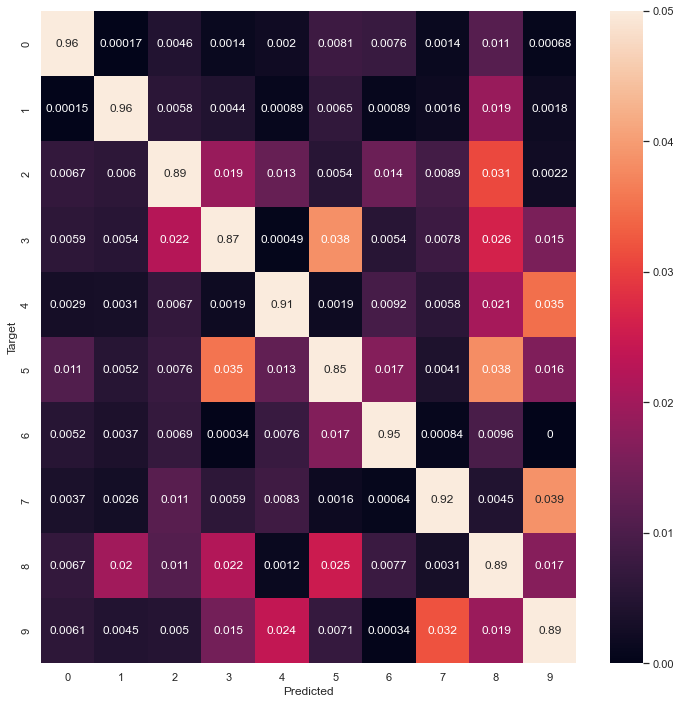

In [37]:
cfm = confusion_matrix(y_train, yhat)
visualize.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.05)

This might seem like a lot of information to take in. But, on the other hand, let's not forget that we have 10 cases to predict. This means that we have 10 cases, and every case might get one out of 10 labels. This gives us 100 cases in total. Considering that, the heatmap is a nice way to quickly spot the problems.

Again, we normalised over the rows. We see that what is actually a three is often mistaken for a five. The same goes the other way around. Also the seven is often mistaken for a nine. Can you spot other common mistakes made by our model?